## データセットの作成

In [ ]:
import random

def generate_sample_data(num, seed=1):
    # 返すリストの作成
    is_cv_list = [] # conversion の有無
    is_treat_list = [] # control か否か
    feature_vector_list = [] # 特徴量（8次元）
    
    random_instance = random.Random(seed) # 乱数の初期化
    
    # 返す関数の特徴量を作成
    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00] # control の持つ重み
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00] # treat により変化する重み
    
    for i in range(num):
        is_treat = random_instance.choice((True, False)) # treat の有無を決定
        feature_vector = [random_instance.random() for n in range(feature_num)] # 特徴ベクトルを乱数で作成
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)]) # 潜在的な conversion rate を算出
        
        # treat を受けた場合は lift_weight を乗算
        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)]) 
        
        # 実際に conversion したかどうかを決定
        is_cv = cv_rate > random_instance.random()
        
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
        
    return is_cv_list, is_treat_list, feature_vector_list

In [ ]:
generate_sample_data(2)

([False, False],
 [True, False],
 [[0.5692038748222122,
   0.8022650611681835,
   0.06310682188770933,
   0.11791870367106105,
   0.7609624449125756,
   0.47224524357611664,
   0.37961522332372777,
   0.20995480637147712],
  [0.43276706790505337,
   0.762280082457942,
   0.0021060533511106927,
   0.4453871940548014,
   0.7215400323407826,
   0.22876222127045265,
   0.9452706955539223,
   0.9014274576114836]])

In [ ]:
from sklearn.linear_model import LogisticRegression

# train データの作成
sample_num = 100000
# generate_sample_data でデータセットを作成
# treat の有無の情報も含み、後で treat と control のデータセットに分離
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# 学習器の生成
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# データを treatment と control に分離
treat_is_cv_list, treat_feature_vector_list, control_is_cv_list, control_feature_vector_list = [], [], [], []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])
        
# 学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01)

In [ ]:
# conversion rate の表示
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))

treatment_cvr 0.0309636212163288
control_cvr 0.029544629532529343


In [ ]:
treat_model.coef_

array([[ 0.31055692,  0.51399856,  0.81982066,  0.25254976, -0.93963072,
         0.0763356 , -0.06571689, -0.00510506]])

In [ ]:
control_model.coef_

array([[ 0.41333519,  0.52454461,  0.89237087, -0.65533809, -0.01929802,
        -0.00734836,  0.03272097,  0.07835321]])

In [ ]:
# seed を変えてテストデータを作成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# それぞれの学習器で cvr を予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# スコアの算出、スコアは control の予測 cvr / treat の予測 cvr
# predict_proba はクラス所属確率のリストを返すために1番目を参照する
score_list = treat_score[:,1] / control_score[:,1]

In [ ]:
%config InlineBackend.figure_formats = {'png', 'retina'}

Text(0, 0.5, 'conversion rate')

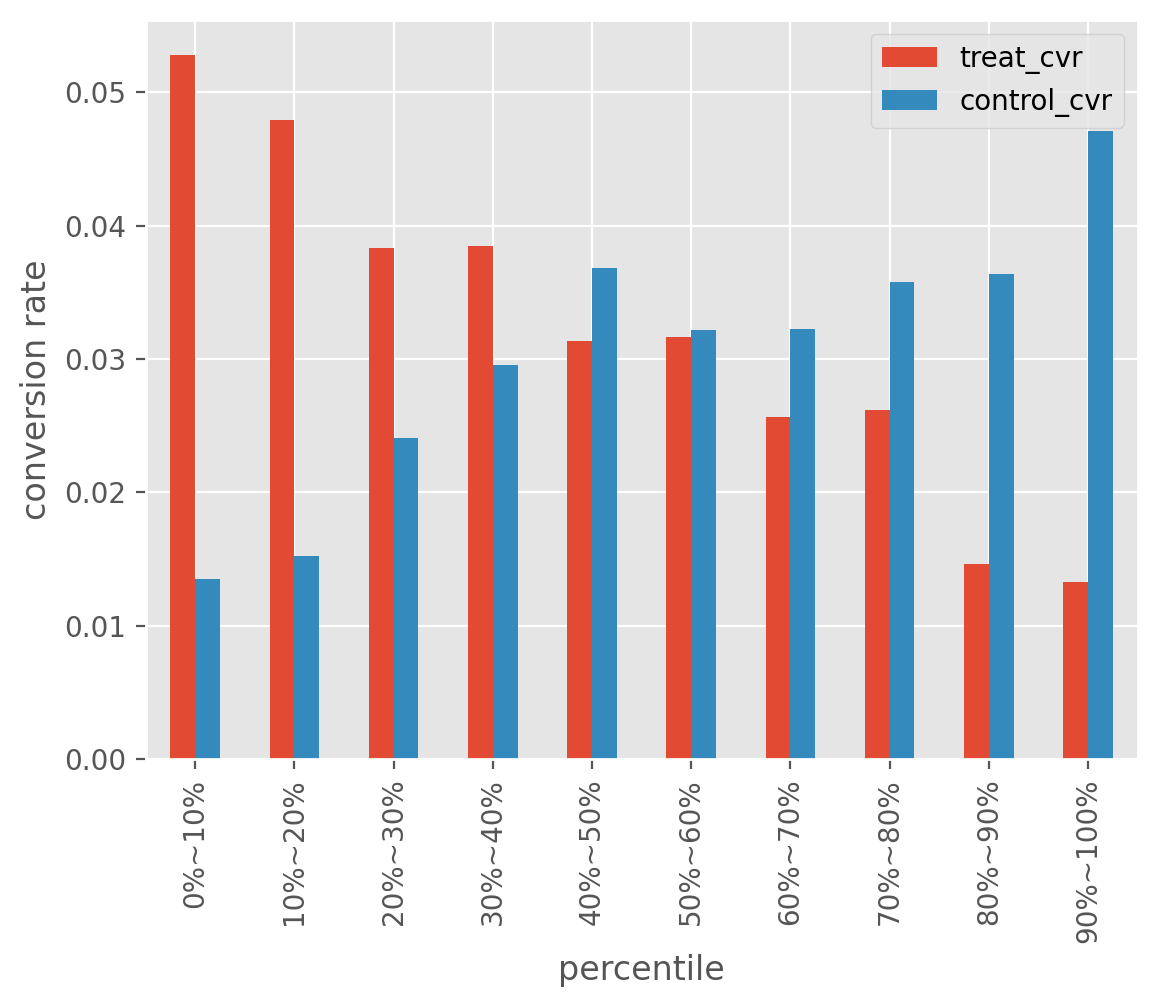

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
plt.style.use('ggplot')

%matplotlib inline

# スコアが高い順番に並び替える
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))

result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

# スコアが高い順番から10 % 区切りでデータを抽出
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # treat, control のデータを抽出しその数をカウント
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

Text(0, 0.5, 'conversion lift')

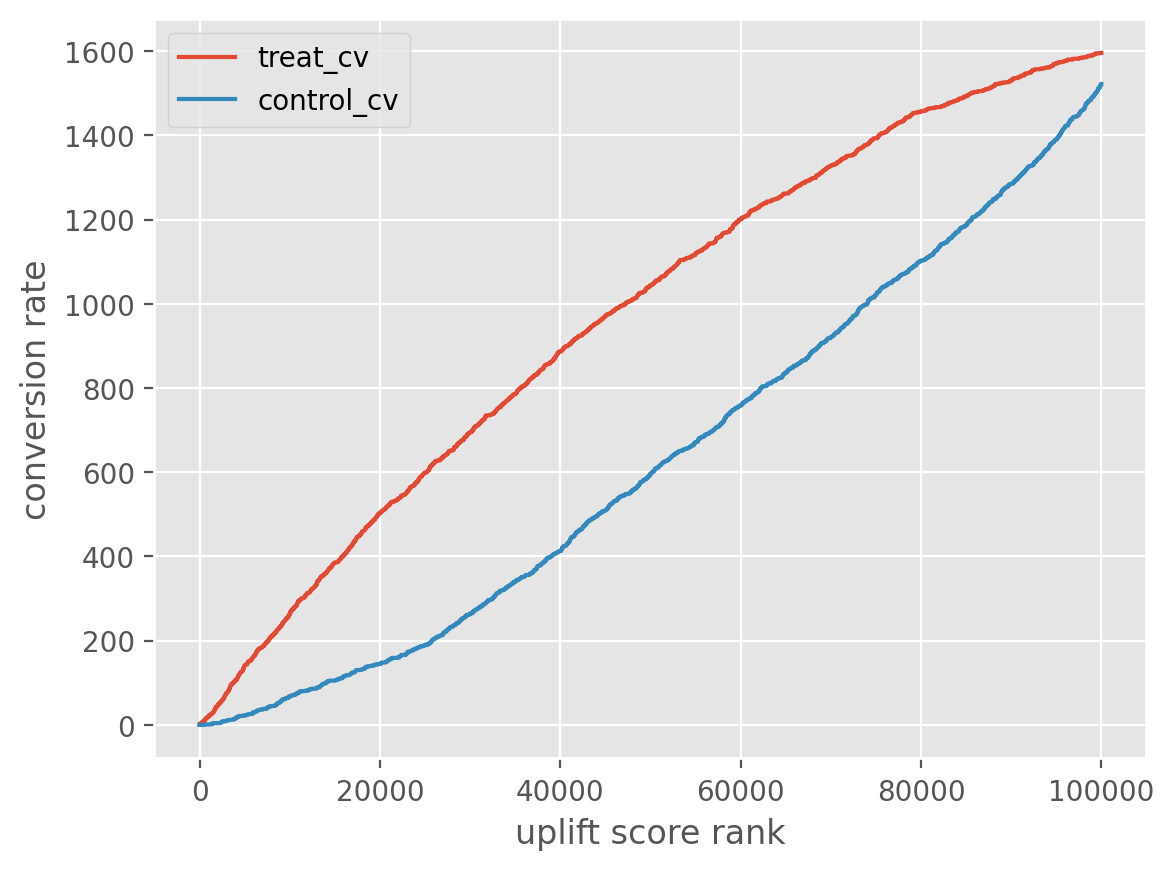

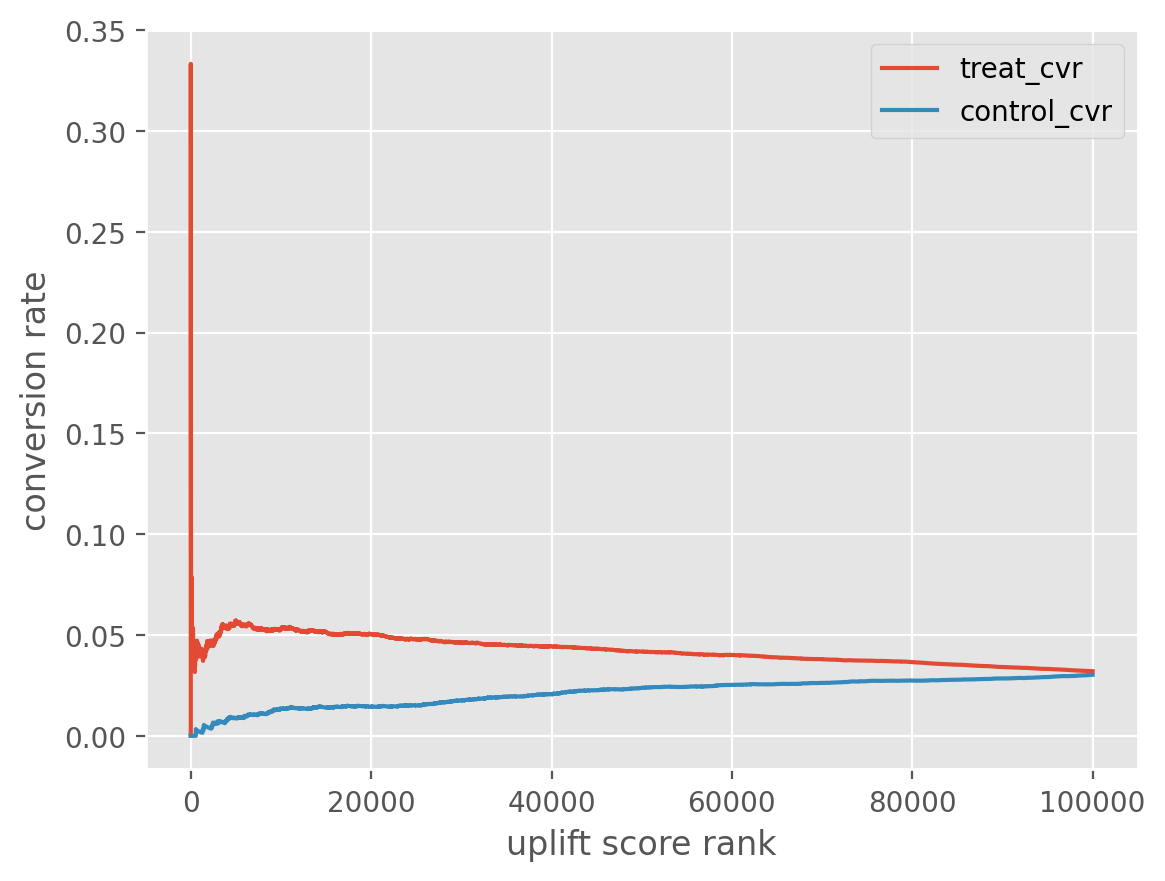

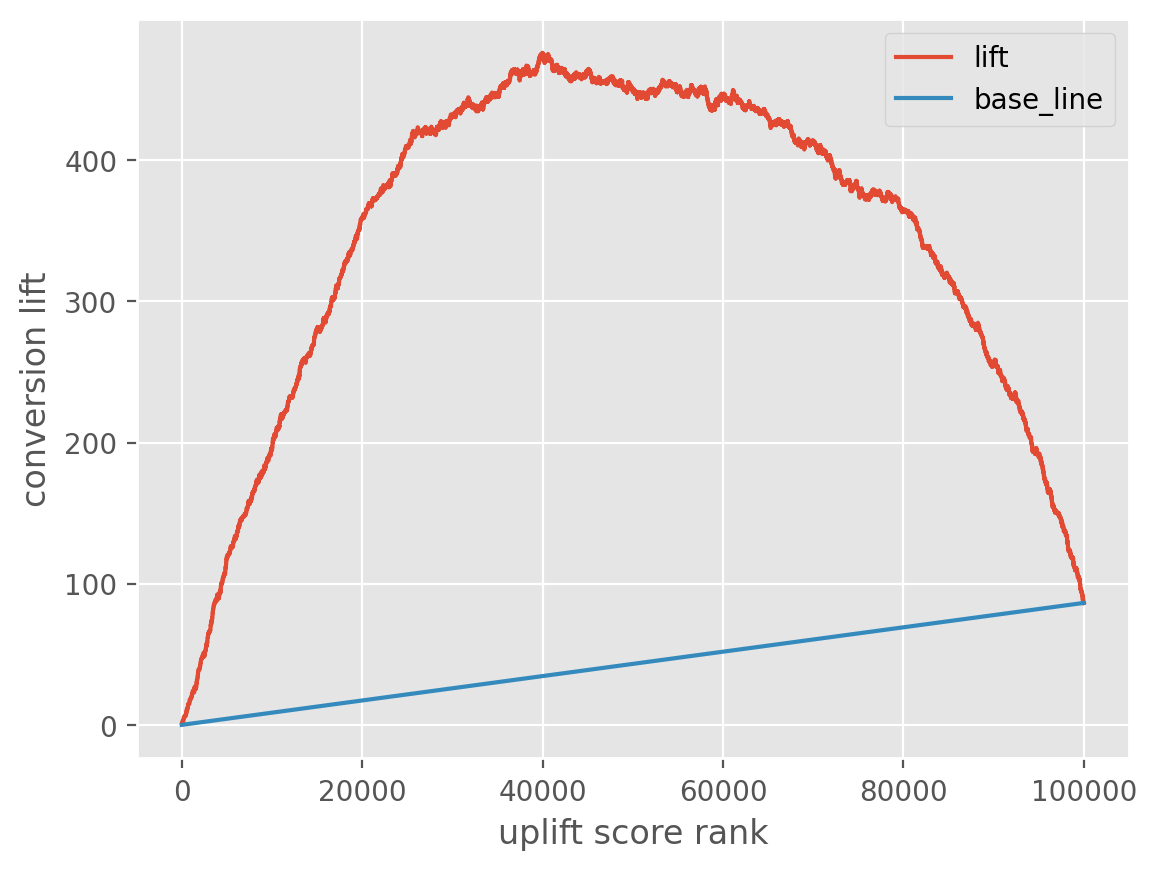

In [ ]:
# スコアごとの集計を行う
treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lif  = 0, 0, 0, 0, 0.0, 0.0, 0.0

stat_data = []

# AUUC の算出
# スコアに対する treat 有無で cvr の件数がどれだけ増加したかを意味する lift を算出
for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
        
    # conversion rate の差に control の人数をかけることで lift を算出
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

# 統計データを DataFrame に変換
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

# ベースラインを追加
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

# DataFrame の可視化
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")

df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")

Text(0, 0.5, 'conversion lift')

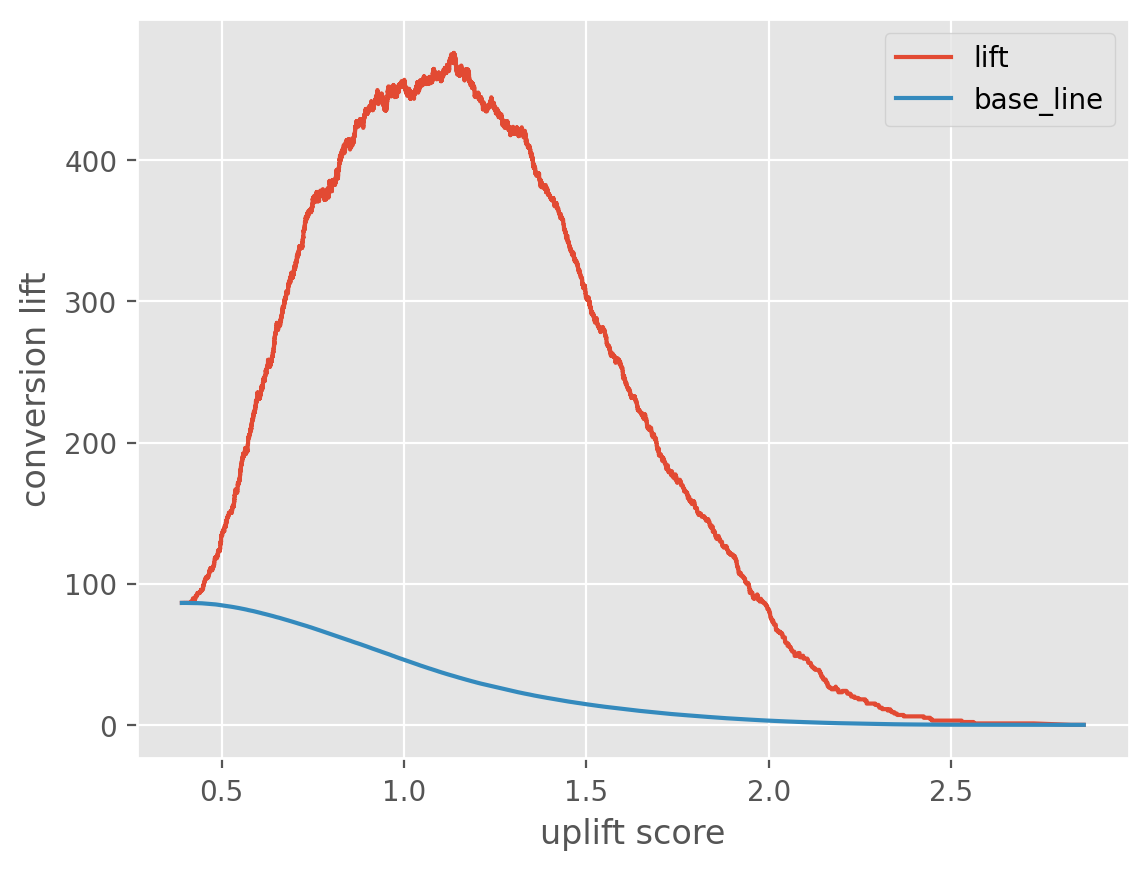

In [ ]:
df.plot(x = "score", y=["lift", "base_line"])
plt.xlabel("uplift score")
plt.ylabel("conversion lift")

In [ ]:
# lift と base_line に囲まれた部分の面積を計算し、"lift" のデータ数で割ることで正規化し、auuc を算出
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

AUUC: 302.1527035956181
